# Examplary office Chilled Water consumption prediction usning LSTM Model

Energy consumption forecasting for buildings has immense value in energy efficiency and sustainability research. Accurate energy forecasting models have numerous implications in planning and energy optimization of buildings and campuses. For new buildings, where past recorded data is unavailable, computer simulation methods are used for energy analysis and forecasting future scenarios. However, for existing buildings with historically recorded time series energy data, statistical and machine learning techniques have proved to be more accurate and quick

## Imports

In [2]:
# Data analysis packages:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.3f'%x)

import warnings

import datetime as dt
from IPython.display import HTML # to see everything
warnings.filterwarnings("ignore")

Import sklearn and statsmodels 

In [3]:
# import sklearn 
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error

Import tensorflow and Keras

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.keras.__version__)

2.0.0-beta0
2.2.4-tf


Import my functions

In [5]:
import supervised_learning as sl
import visualization as vis
%load_ext autoreload
%autoreload 2

## Load Dataset -- Steam

In [6]:
office = pd.read_csv('data_folder/cleaned_office_data.csv', index_col=['timestamp'], parse_dates=['timestamp'])
print('Dataset record for building_id = 1249:', office.shape)
steam_consumption = office[office['meter']==2]
steam_consumption.head(3)

Dataset record for building_id = 1249: (35136, 9)


,meter,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,,
2016-01-01 00:00:00,2,899.640,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 01:00:00,2,1019.590,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 02:00:00,2,1319.470,5.600,4.000,-0.600,0.000,1019.500,300.000,2.600


## Exploratory Data Analysis or (EDA)

In [7]:
steam_consumption.drop(columns=['meter'], inplace=True)
print(steam_consumption.shape)
steam_consumption.head(3)

(8784, 8)


,meter_reading,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,899.640,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 01:00:00,1019.590,5.600,0.000,-0.600,0.000,1019.500,300.000,2.600
2016-01-01 02:00:00,1319.470,5.600,4.000,-0.600,0.000,1019.500,300.000,2.600


In [8]:
steam_consumption.isin([0]).sum()

meter_reading           93
air_temperature        127
cloud_coverage        5883
dew_temperature        152
precip_depth_1_hr     7791
sea_level_pressure       0
wind_direction        1243
wind_speed            1190
dtype: int64

In [9]:
# Check if dataframe has a zero element
# elec_consumption['wind_direction'].isin([0]).sum() #any().any()

In [10]:
# %load -r 14-27 visualization.py

The energy consumption is in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

In [11]:
import matplotlib.pyplot as plt

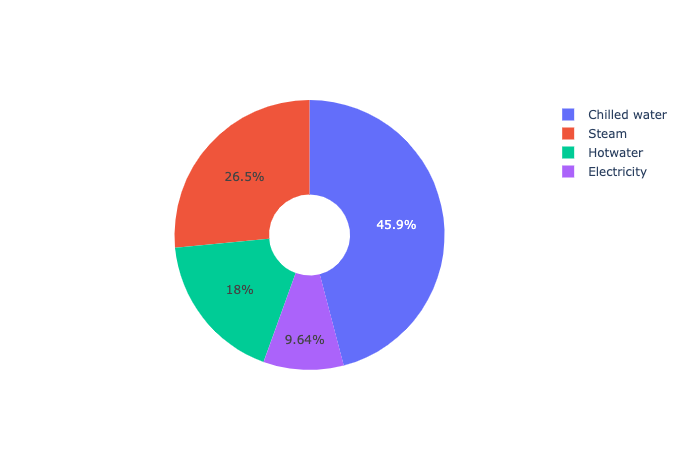

In [16]:
labels = 'Electricity', 'Chilled water', 'Steam', 'Hotwater'
sizes = list(office.groupby(by='meter')['meter_reading'].sum())
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

fig = go.Figure(data=[go.Pie(labels=labels, values=sizes, hole=.3)])
fig.show()

### Box plots and outlier detection

In [17]:
# B=plt.boxplot(steam_consumption.meter_reading)
# [item.get_ydata() for item in B['whiskers']]

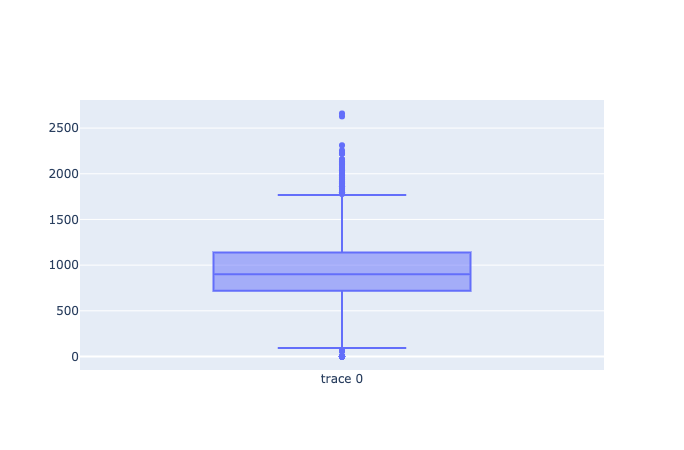

In [18]:
fig = go.Figure()
whiskers_top = 6000
median = steam_consumption.loc[steam_consumption['meter_reading'] < whiskers_top, 'meter_reading'].median()
# steam_consumption['meter_reading'] = np.where(steam_consumption['meter_reading'] < whiskers_bottom, median, steam_consumption['meter_reading'])
steam_consumption['meter_reading'] = np.where(steam_consumption['meter_reading'] > whiskers_top, median, steam_consumption['meter_reading'])
fig.add_trace(go.Box(y=steam_consumption['meter_reading']))

fig.show()
# ax = sns.boxplot(x=steam_consumption["meter_reading"])

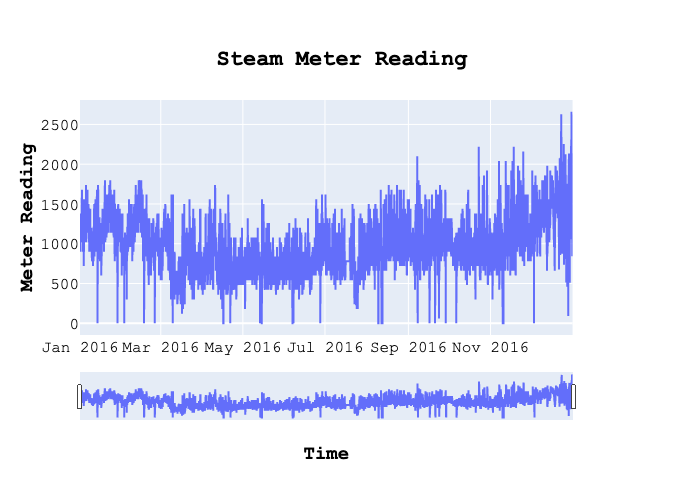

In [19]:
# Make subplot figure 
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(go.Scatter(x=steam_consumption.index,
                         y=steam_consumption['meter_reading'],
                         name="Actual")) #line_color='lightblue'
fig.update_layout(xaxis_rangeslider_visible=True)
fig.update_layout(width=1000, height=500,
                      title= {'text': "<b>Steam Meter Reading<b>", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="<b>Time<b>",
                      yaxis_title="<b>Meter Reading<b>",
                      font=dict(family="Courier New, monospace", size=16, color='black'))
fig.show()

In [20]:
import plotly.graph_objects as go
import plotly
from plotly.subplots import make_subplots
plotly.offline.init_notebook_mode(connected=True)

## Features and labels
for this capstone project, I wanted to build a model that will predict the future energy consumption and air temperature variation as a function of all other eight features.

In [21]:
target_names = ['meter_reading']#, 'air_temperature']
shift_days = 1
shift_steps = shift_days * 24 # I wanted to shift the record by shift_steps hours.
df_targets = steam_consumption[target_names].shift(-shift_steps)
df_targets.head(3)

,meter_reading
timestamp,
2016-01-01 00:00:00,1259.500
2016-01-01 01:00:00,1259.500
2016-01-01 02:00:00,1259.500


to check we successfully shifted by 24 hours, I took the 24 to 27 records from the original data

In [22]:
# check the raws from 24- 27
steam_consumption[target_names].iloc[24:27]

,meter_reading
timestamp,
2016-01-02 00:00:00,1259.500
2016-01-02 01:00:00,1259.500
2016-01-02 02:00:00,1259.500


good! new we succesfully shifted by 24 hours, let us split the data set into feature and target.

In [23]:
# features
x_data = steam_consumption.values[0:-shift_steps]
print('    Feature Shape:', x_data.shape)
 
# target
y_data = df_targets.values[:-shift_steps]
print('    Target Shape:', y_data.shape)

    Feature Shape: (8760, 8)
    Target Shape: (8760, 1)


In [24]:
# These are the input-signals for the training- and test-sets:
num_data = len(x_data)
train_split = 0.85
num_train = int(train_split * num_data)
num_test = num_data - num_train
print('Training observations:', num_train)
print('Validation observations:', num_test)
x_train = x_data[0:num_train]
x_test  = x_data[num_train:]
print('Total observations:', (len(x_train) + len(x_test)))

Training observations: 7446
Validation observations: 1314
Total observations: 8760


In [25]:
# Check the shape
x_train.shape, x_test.shape

((7446, 8), (1314, 8))

In [26]:
# These are the output-signals for the training- and test-sets:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print('Total test observations:', (len(y_train) + len(y_test)))
y_train.shape, y_test.shape

Total test observations: 8760


((7446, 1), (1314, 1))

In [27]:
num_x_signals = x_data.shape[1] # 8
num_y_signals = y_data.shape[1] # 2
print('Number of input-signals:', num_x_signals, 'and shape:', x_train.shape )
print('Number of output-signals:', num_y_signals, 'and shape', y_train.shape)

Number of input-signals: 8 and shape: (7446, 8)
Number of output-signals: 1 and shape (7446, 1)


## Scaled Data

In [28]:
# x_data[24:27] # I shifted the data by one day

In [29]:
print('Min and Max x_train data')
print('    Min:', np.min(x_train))
print('    Max:', np.max(x_train))
x_scaler = MinMaxScaler() # feature_range=(0, 1)
x_scaled_train = x_scaler.fit_transform(x_train)
print('Min and Max x_train_scaled data')
print('    Min:', np.min(x_scaled_train))
print('    Max:', np.max(x_scaled_train))

Min and Max x_train data
    Min: -25.6
    Max: 2219.11
Min and Max x_train_scaled data
    Min: 0.0
    Max: 1.0


In [30]:
x_scaled_test = x_scaler.transform(x_test)
print('Min and Max x_test data')
print('    Min:', np.min(x_test))
print('    Max:', np.max(x_test))

# target MinMaxScaler
y_scaler = MinMaxScaler() # feature_range=(-1, 1)
y_scaled_train = y_scaler.fit_transform(y_train)
y_scaled_test = y_scaler.transform(y_test)
print('Min and Max y_test_scaled data')
print('    Min:', np.min(y_scaled_test))
print('    Max:', np.max(y_scaled_test))

Min and Max x_test data
    Min: -23.3
    Max: 2628.11
Min and Max y_test_scaled data
    Min: 0.0
    Max: 1.198453434034365


In [31]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('-------')
print(x_scaled_test.shape)
print(y_scaled_test.shape)
# y_train_scaled

(7446, 8)
(7446, 1)
-------
(1314, 8)
(1314, 1)


The data we have now is one long-time series with 20 input signals so that each time step has 8 input signals and 2 output signals

## Data Generator

In [32]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)

(7446, 8)
(7446, 1)


call the batch generator function and create a training bach

In [33]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_scaled_train[idx:idx+sequence_length]
            y_batch[i] = y_scaled_train[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

The above function will break the long-time series signal into small subsequences and create a batch so that we can use that for training the network

```python
reshape input to be [samples, time steps, features]
```

In [34]:
# reshape input to be [samples, time steps, features]
batch_size = 64 # batch size of 32 is a good starting point, and you should also try with 64, 128, and 256.
sequence_length = shift_steps # 24 * 7

# create the batch-generator
generator = batch_generator(batch_size, sequence_length)

# test the batch-generator to see if it works 
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(64, 24, 8)
(64, 24, 1)


we get a batch output where we have a batch size of 64 sequences, each sequence has 24, and 8 input signals and 2 output signals. 

I create a validation dataset from the testing data

In [35]:
validation_data = (np.expand_dims(x_scaled_test, axis=0),
                   np.expand_dims(y_scaled_test, axis=0))

In [36]:
print('x_test_validation', validation_data[0].shape)
print('y_test_validation', validation_data[1].shape)

x_test_validation (1, 1314, 8)
y_test_validation (1, 1314, 1)


## Create the Recurrent Neural Network Architecture

In [37]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                               TensorBoard, ReduceLROnPlateau, CSVLogger)

### Initalize the RNN
Now let us instantiate an RNN model

In [38]:
# clear a model
tf.keras.backend.clear_session()

In [39]:
# Initializing RNN 
steam_dropout_model = Sequential()

#### Adding the LSTM layers and some Dropout regularization

In [40]:
from keras import regularizers

Using TensorFlow backend.


In [41]:
# Adding the first LSTM layer and some Dropout regularisation
steam_dropout_model.add(LSTM(units=100, return_sequences=True, dropout=0.2, #kernel_regularizer=regularizers.l2(0.01),
                            input_shape=(None, num_x_signals,)))

In [42]:
# Adding the second LSTM layer and some Dropout regularisation
steam_dropout_model.add(LSTM(units=100, return_sequences=True, dropout=0.2)) #kernel_regularizer=regularizers.l2(0.01), 

In [43]:
steam_dropout_model.add(Dense(num_y_signals, activation='sigmoid')) #, kernel_regularizer=regularizers.l2(0.01),


### Loss Function

In [44]:
warmup_steps = 50

load the loss_mse_warmup function below

In [45]:
# %load -r 41-63 supervised_learning.py

### Compile Model

In [46]:
optimizer = RMSprop(lr=1e-3)
# optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

In [47]:
# model.compile(loss=loss_mse_warmup, optimizer=optimizer, metrics=['acc'])
# chw_baseline_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['acc'])
steam_dropout_model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])
steam_dropout_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 100)         43600     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense (Dense)                (None, None, 1)           101       
Total params: 124,101
Trainable params: 124,101
Non-trainable params: 0
_________________________________________________________________


### Callback Functions

In [48]:
path_checkpoint = 'weights/model_weights_steam_dropout.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                     monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)

In [49]:
callback_tensorboard = TensorBoard(log_dir='./logs/',
                                   histogram_freq=0,
                                   write_graph=False) #'./23_logs/'

In [50]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [51]:
csv_logger = CSVLogger('logs/steam_dropout_model.csv')

In [52]:
# callback lists 
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr,
             csv_logger] # check the logger

### Fit the RNN to the training set 

In [53]:
%%time
steam_dropout_history = steam_dropout_model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
 99/100 [============================>.] - ETA: 0s - loss: 0.0148 - mse: 0.0148
Epoch 00001: val_loss improved from inf to 0.03188, saving model to weights/model_weights_steam_dropout.h5
100/100 [==============================] - 18s 180ms/step - loss: 0.0148 - mse: 0.0148 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0126 - mse: 0.0126
Epoch 00002: val_loss did not improve from 0.03188

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 9s 88ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0488 - val_mse: 0.0488
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 0.0118 - mse: 0.0118
Epoch 00003: val_loss improved from 0.03188 to 0.02896, saving model to weights/model_weights_steam_dropout.h5
100/100 [===========================

### Evaluate the model

In [54]:
# evaluete training set
steam_dropout_model.evaluate(x_batch, y_batch)

64/64 [==============================] - 1s 16ms/sample - loss: 0.0109 - mse: 0.0109


[0.010902771260589361, 0.010902771]

In [55]:
# evaluate test set
steam_dropout_model.evaluate(validation_data[0], validation_data[1])
print('validation set should be a 3D arrray', 
      validation_data[0].shape, validation_data[1].shape)

1/1 [==============================] - 2s 2s/sample - loss: 0.0331 - mse: 0.0331
validation set should be a 3D arrray (1, 1314, 8) (1, 1314, 1)


In [56]:
print(x_scaled_train.shape)
print(y_scaled_train.shape)
print('-----')
print(x_scaled_test.shape)
print(y_scaled_test.shape)
type(x_scaled_train)

(7446, 8)
(7446, 1)
-----
(1314, 8)
(1314, 1)


numpy.ndarray

In [57]:
# this is also a validation test
result = steam_dropout_model.evaluate(x=np.expand_dims(x_scaled_test, axis=0),
                        y=np.expand_dims(y_scaled_test, axis=0))

1/1 [==============================] - 2s 2s/sample - loss: 0.0331 - mse: 0.0331


In [156]:
print("loss (test-set):", result)

loss (test-set): [0.03410143405199051, 0.034101434]


load plot comparision plot

In [150]:
# %load -r 30-66 visualization.py

In [59]:
date_train = steam_consumption.index[:num_train]
date_test = steam_consumption.index[num_train:-shift_steps]
print(len(date_train))
print(len(date_test))

7446
1314


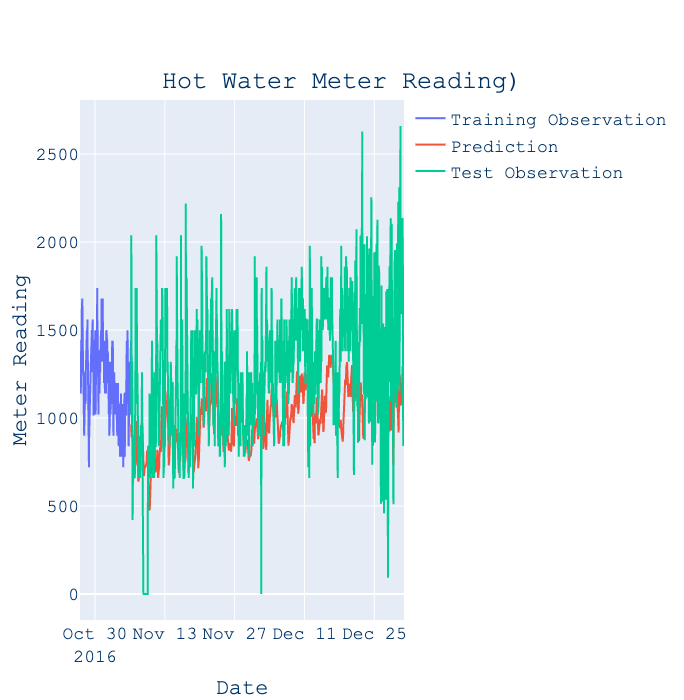

In [60]:
x = np.expand_dims(x_scaled_test, axis=0)
y_pred = steam_dropout_model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])


y_train_reshaped = y_train.reshape((-1))
y_test_reshaped = y_test.reshape((-1))
y_pred_reshaped = y_pred_rescaled.reshape((-1))

trace1 = go.Scatter(
    x = steam_consumption.index[7200:num_train],
    y = y_train_reshaped,
    mode = 'lines',
    name = 'Training Observation'
)
trace2 = go.Scatter(
    x = date_test,
    y = y_pred_reshaped,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = y_test_reshaped,
    mode='lines',
    name = 'Test Observation'
)
layout = go.Layout(width=1400, height=700,
    title = {'text': "Hot Water Meter Reading)", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Meter Reading", }
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.update_layout(font=dict(family="Courier New, monospace", size=18, color="#003366", )) # "#7f7f7f"
fig.show()

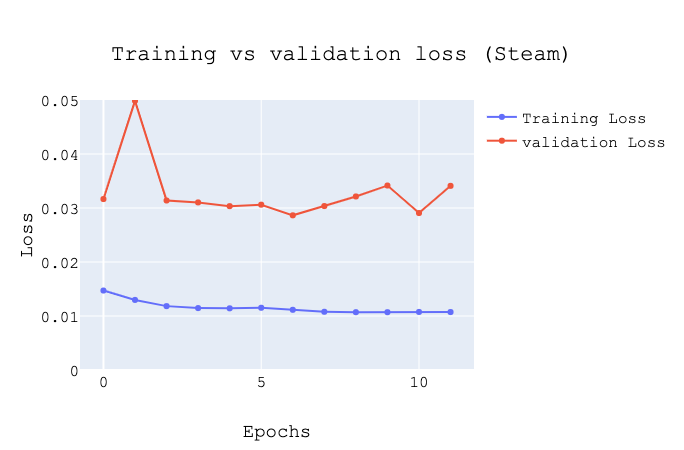

In [153]:
vis.plot_train_vs_val_loss(history=steam_dropout_history, a='Steam')

# Additional

## Performance Metric
The mean percentage error (MPE) is the computed average of percentage errors by which forecasts of a model differ from actual values of the quantity being forcast. 
The formula for the mean percentage error is

In [63]:
# Mean Percent Error
mpe = np.sum((y_test-y_pred_rescaled)/y_test)/len(y_test)
mpe*100

-inf

In [62]:
y_pred = steam_dropout_model.predict(np.expand_dims(x_scaled_test, axis=0))
# x = np.expand_dims(x, axis=0)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

In [ ]:
# plot_comparison(start_idx=4000, length=1000, train=True, model=steam_dropout_model)

### Example from test set

In [ ]:
# plot_comparison(start_idx=1000, length=1000, train=False, model=steam_dropout_model)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

In [95]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]

        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [67]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [72]:
def calculate_errors(train=True, model=None):
    
    if train:
        # Use training-data.
        x = x_scaled_train
        y_true = y_train
        print('Traning data:')
    else:
        # Use test-data.
        x = x_scaled_test
        y_true = y_test
        print('Testing data:')
    
    x = np.expand_dims(x, axis=0)

    y_pred = model.predict(x)
    
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    for signal in range(len(target_names)):
        signal_pred = y_pred_rescaled[:, signal]
        signal_true = y_true[:, signal]
        
        print('    Mean Absolute Error:', mean_absolute_error(signal_true, signal_pred))
        print('    Mean Absolute Persentage Error:', mean_absolute_error(signal_true, signal_pred)/np.mean(y_true))
        print('    Root Mean Squared Error:',np.sqrt(mean_squared_error(signal_true, signal_pred)))

In [65]:
# calculate_errors(train=True, model=steam_dropout_model)

In [71]:
calculate_errors(train=False, model=steam_dropout_model)

Testing data:
    Mean Absolute Error: 325.1157586623472
    Mean Absolute percent Error: 0.2594751595243222
    Root Mean Squared Error: 403.6350605932255


In [ ]:
plt.figure(figsize=(10,5))
plt.plot(steam_dropout_history.history['loss'], label='Train Loss')
plt.plot(steam_dropout_history.history['val_loss'], label='Test Loss')
plt.title('Model train vs validation loss for steam', fontsize=20)
plt.ylabel('loss', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
# sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
# plt.savefig('image/model_loss_steam')
plt.show();

In [ ]:
def plot_train_vs_val_loss(history=None):
    """
    plot model accuracy, comparing training and testing accuracies.
    Arguments:
        history: model history 
    Outputs:
        MSE loss plot 
    """
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=history.history['loss'], name="Train Loss"))
    fig.add_trace(go.Scatter(y=history.history['val_loss'], name="Train Loss"))
    fig.update_layout(width=1000, height=500,
                      title= {'text': "Train vs validation loss (Steam)", 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'},
                      xaxis_title="Epochs",
                      yaxis_title="Loss",
                      font=dict(family="Courier New, monospace", size=16, color='black')
                     )
    fig.write_image('image/train2.png')
    fig.show();

In [ ]:
plot_train_vs_val_loss(history=steam_dropout_history)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(steam_dropout_history.history['acc'], label='Train Accuracy')
plt.plot(steam_dropout_history.history['val_acc'], label='Test Accuracy')
plt.title('Model train vs validation accuracy', fontsize=20)
plt.ylabel('accuracy', fontsize=16)
plt.xlabel('epochs', fontsize=16)
plt.xticks(fontsize=12), plt.yticks(fontsize=12)
plt.legend(loc='upper right', fontsize=14)
sns.set_context("paper", font_scale=1.3)
sns.set_style('white')
plt.show();